# About the Problem

The **Traveling Salesperson Problem (TSP)** is a well-known combinatorial optimization problem that seeks to determine a least cost route for a salesperson to visit a given set of cities exactly once and return to the starting point. Formally, it is defined on a weighted graph where nodes represent cities, edges represent connections between cities, and edge weights denote travel costs (such as distance or time). The objective is to minimize the total travel cost while ensuring that each city is visited once.

# Import Packages and Read Data

In [80]:
import gurobipy as gp
from gurobipy import quicksum as qsum 
from gurobipy import GRB
import json
import pandas as pd
import util
import networkx as nx
import matplotlib.pyplot as plt
import time

df_cities = pd.read_csv('cities.csv')

# Cities

In [81]:
print(df_cities.head(10))

         City Airport Code  Latitude  Longitude  X Coordinate  Y Coordinate
0      Dallas          ADS  32.96856  -96.83644  3.131644e+06  1.136450e+06
1  Washington          WSG  40.13647  -80.29019  4.971502e+06  2.129998e+06
2      Denver          APA  39.57012 -104.84929  2.240656e+06  2.047965e+06
3      Austin          AUM  43.66264  -92.93292  3.565695e+06  2.656997e+06
4   Nashville          BNA  36.12447  -86.67818  4.261190e+06  1.562602e+06
5      Boston          BOS  42.36294  -71.00639  6.003813e+06  2.459338e+06
6   Charlotte          CLT  35.21375  -80.94906  4.898239e+06  1.437947e+06
7     Houston          CXO  30.35340  -95.41508  3.289691e+06  7.947587e+05
8     Detroit          DET  42.40933  -83.01017  4.669054e+06  2.466322e+06
9     Phoenix          DVT  33.68831 -112.08256  1.436353e+06  1.232237e+06


# Visualization

In [82]:
dist_min = 0
dist_max = 2000
G = util.get_cities_graph(df_cities, dist_min, dist_max)
pos = nx.get_node_attributes(G, 'pos')
labels = nx.get_edge_attributes(G, 'weight')
formatted_labels = {k: f"{int(v)}" for k, v in labels.items()}

# Visualization (2)

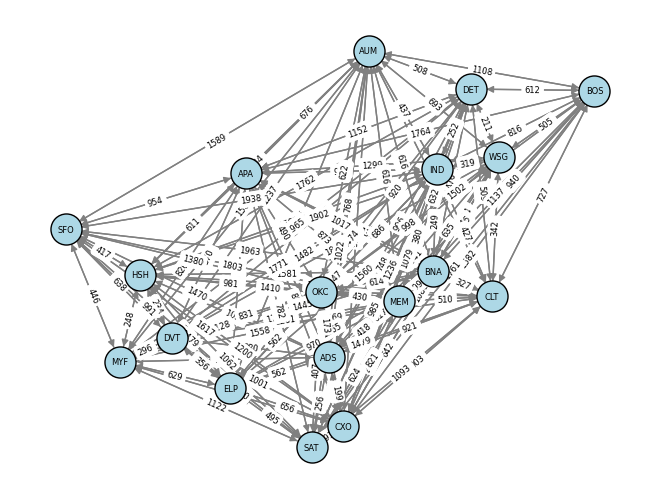

In [83]:
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color='gray', font_size=6, edgecolors='black')

nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, 
                             font_size=6);

# Nearest Neighbor Heuristic

In [84]:
def nearest_neighbor_heuristic(G):
    visited = []
    current_node = list(G.nodes())[0]
    visited.append(current_node)
    while len(visited) < len(G.nodes()):
        jPrime = min([G[current_node][j]['weight'] for j in G.successors(current_node) if j not in visited])
    visited.append(visited[0])
    return visited

# Get Solution

In [85]:
start_time = time.time()
tour = nearest_neighbor_heuristic(G)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("Tour:", tour)
edges_used = list(zip(tour, tour[1:]))
cost = sum(G[u][v]['weight'] for u, v in edges_used)
formatted_cost = round(cost)
print("Cost of tour:", formatted_cost)
print("Optimization time:", execution_time, "seconds")

Tour: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
Cost of tour: 8255
Optimization time: 0.0002 seconds


# Visualize Solution

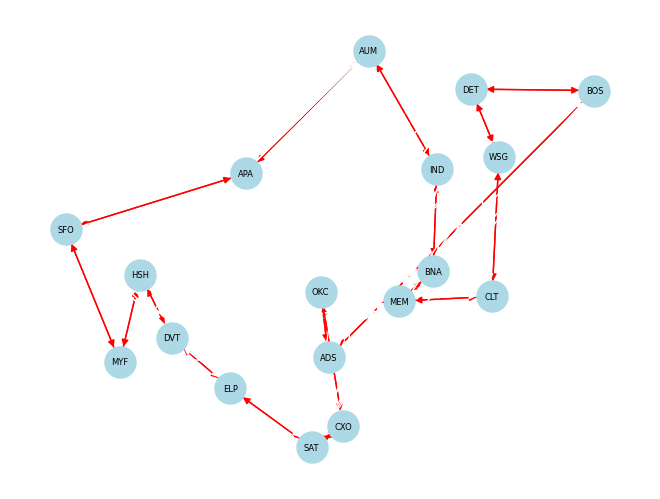

In [86]:
edge_colors = ['red' if (u, v) in edges_used or (v,u) in edges_used else 'white' 
               for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color=edge_colors, font_size=6)


# Gurobipy Model

In [87]:
m = gp.Model("TSP")

depot = 'ADS'
x = m.addVars(G.edges, name="x", vtype=GRB.BINARY)
u = m.addVars(G.nodes, name="u")

m.setObjective(qsum(G[i][j]['weight'] * x[i,j] 
                    for i,j in G.edges if (i,j) in G.edges), 
               GRB.MINIMIZE)
m.addConstrs((qsum(x[i, j] for j in G.successors(i)) == 1 for i in G.nodes), 
             name="Out")
m.addConstrs((qsum(x[j, i] for j in G.predecessors(i)) == 1 for i in G.nodes), 
             name="In")
# add subtour elimination constraints

# Optimize

In [88]:
m.Params.LogToConsole = 0 #turn off output
start_time = time.time()
m.optimize()
print("Optimal objective value:", round(m.ObjVal))
end_time = time.time()
execution_time = round(end_time - start_time, 3)
print("Optimization time:", execution_time, "seconds")
percentage_above_optimal = ((formatted_cost - m.ObjVal) / m.ObjVal) * 100
print("Heuristic percentage above optimal:", 
      round(percentage_above_optimal, 2), "%")

Optimal objective value: 6957
Optimization time: 0.123 seconds
Heuristic percentage above optimal: 18.67 %


# Visualize Gurobi Solution

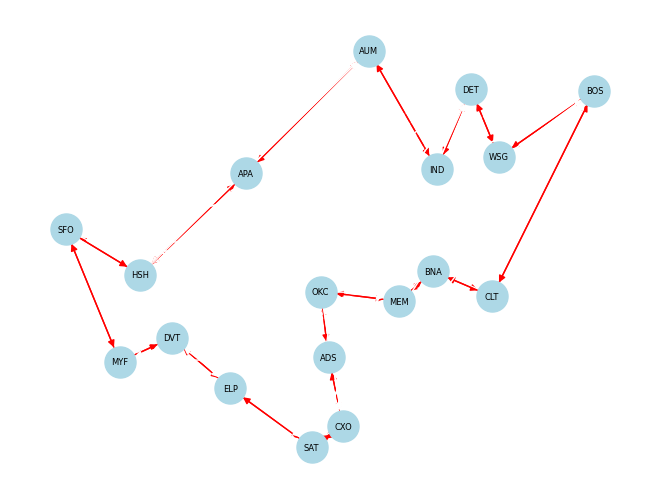

In [89]:
edges_used_gurobi = [(i, j) for i, j in G.edges if x[i, j].x > 0.5]
edge_colors = ['red' if (u, v) in edges_used_gurobi or (v,u) in edges_used_gurobi else 'white' 
               for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color=edge_colors, font_size=6)
plt.show()